## Carga datos y limpieza

In [2]:
#Python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

#Guardar modelos
from scipy.sparse import csr_matrix
from scipy import sparse


#LDA
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from pprint import pprint


In [3]:

file_path = "https://raw.githubusercontent.com/juankquintana/aprendizaje-no-supervisado/main/Proyecto/data/movies_metadata.csv"

metadata = pd.read_csv(file_path)

metadata.head(1)

C:\Users\WD\AppData\Local\Temp\ipykernel_2200\3950954798.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(file_path)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0


In [4]:
import ast
def columnas_transformadas(metadata, columna, indicador, nuevo_nombre):
    # Crear una nueva columna temporal con los datos convertidos
    metadata['col_p'] = metadata[columna].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    # Extraer el valor deseado
    metadata[nuevo_nombre] = metadata['col_p'].apply(lambda x: [genre_p[indicador] for genre_p in x] if isinstance(x, list) else [])
    # Eliminar la columna temporal
    metadata = metadata.drop(columns=['col_p'])
    # Mostrar las primeras filas del nuevo nombre de columna
    print(metadata[nuevo_nombre].head(5))
    return metadata


metadata = columnas_transformadas(metadata, 'genres', 'name', 'genre_names')

0     [Animation, Comedy, Family]
1    [Adventure, Fantasy, Family]
2               [Romance, Comedy]
3        [Comedy, Drama, Romance]
4                        [Comedy]
Name: genre_names, dtype: object


In [5]:
file_path_keywords = "https://raw.githubusercontent.com/juankquintana/aprendizaje-no-supervisado/main/Proyecto/data/keywords.csv"

df_keywords = pd.read_csv(file_path_keywords)

df_keywords.head(5)


,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [6]:
import ast

# Convertir la columna 'keywords' de string a una lista de diccionarios
df_keywords['keywords'] = df_keywords['keywords'].apply(ast.literal_eval)
df_keywords_exploded = df_keywords.explode('keywords')

df_keywords_exploded['keyword_id'] = df_keywords_exploded['keywords'].apply(lambda x: x['id'] if isinstance(x, dict) else None)
df_keywords_exploded['keyword_name'] = df_keywords_exploded['keywords'].apply(lambda x: x['name'] if isinstance(x, dict) else None)

# Eliminar la columna original 'keywords'
df_keywords_exploded = df_keywords_exploded.drop(columns=['keywords'])

print(df_keywords_exploded.head(10))

     id  keyword_id       keyword_name
0   862       931.0           jealousy
0   862      4290.0                toy
0   862      5202.0                boy
0   862      6054.0         friendship
0   862      9713.0            friends
0   862      9823.0            rivalry
0   862    165503.0      boy next door
0   862    170722.0            new toy
0   862    187065.0  toy comes to life
1  8844     10090.0         board game


C:\Users\WD\AppData\Local\Temp\ipykernel_2200\3305871799.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='movie_count', y='keyword_name', data=top_25_keywords, palette='viridis')


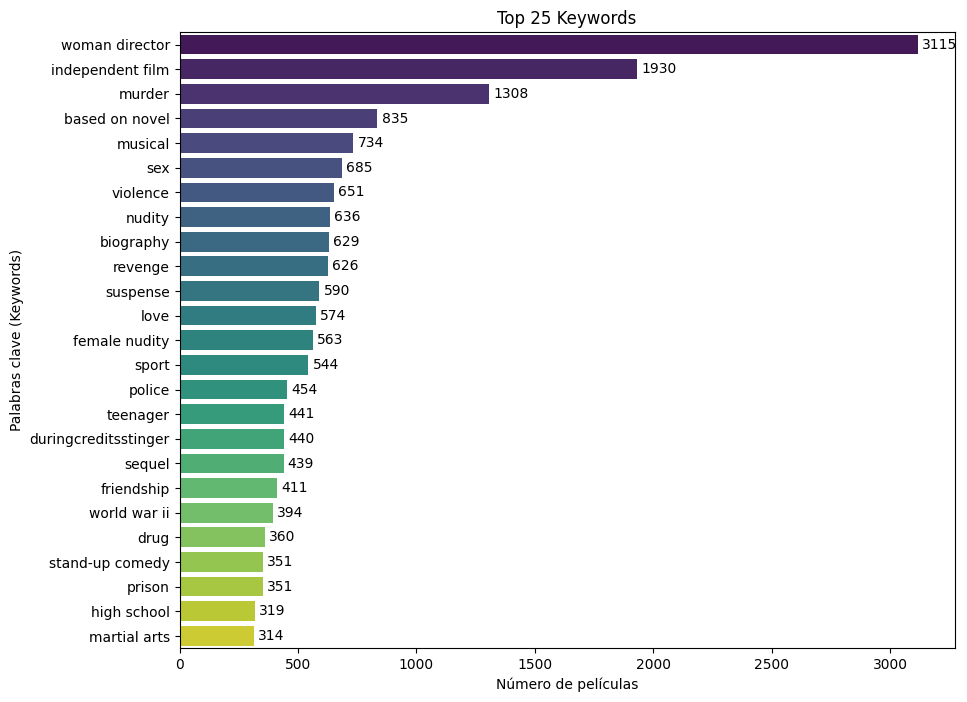

In [7]:
keyword_counts = df_keywords_exploded.groupby('keyword_name')['id'].count().reset_index(name='movie_count')

# Ordenar los datos por el número de películas para una mejor visualización
keyword_counts = keyword_counts.sort_values('movie_count', ascending=False)

top_25_keywords = keyword_counts.head(25)

# Graficar los datos
plt.figure(figsize=(10, 8))
ax = sns.barplot(x='movie_count', y='keyword_name', data=top_25_keywords, palette='viridis')

# Agregar etiquetas de datos
for i in ax.containers:
    ax.bar_label(i, fmt='%d', label_type='edge', padding=3)

plt.xlabel('Número de películas')
plt.ylabel('Palabras clave (Keywords)')
plt.title('Top 25 Keywords')
plt.show()

In [8]:
df_grouped_keywords = df_keywords_exploded.groupby('id')['keyword_name'].apply(list).reset_index()

df_grouped_keywords.head()

,id,keyword_name
0,2,"[underdog, prison, factory worker, prisoner, h..."
1,3,"[salesclerk, helsinki, garbage, independent film]"
2,5,"[hotel, new year's eve, witch, bet, hotel room..."
3,6,"[chicago, drug dealer, boxing match, escape, o..."
4,11,"[android, galaxy, hermit, death star, lightsab..."


In [9]:
#!python -m spacy download en_core_web_sm

### Cruzar titulo original y generos a la lista

In [10]:
# Convert 'movieId' column in df_ratings to object type
df_grouped_keywords['id'] = df_grouped_keywords['id'].astype(str)

# Now perform the merge operation
df_keywords_title = pd.merge(df_grouped_keywords, metadata[['id', 'original_title','genre_names']],
                     left_on='id', right_on='id', how='left')

# Seleccionar solo las columnas que necesitas
df_keywords_title = df_keywords_title[['id','original_title', 'keyword_name','genre_names']]

# Mostrar el DataFrame final
df_keywords_title.head()

,id,original_title,keyword_name,genre_names
0,2,Ariel,"[underdog, prison, factory worker, prisoner, h...","[Drama, Crime]"
1,3,Varjoja paratiisissa,"[salesclerk, helsinki, garbage, independent film]","[Drama, Comedy]"
2,5,Four Rooms,"[hotel, new year's eve, witch, bet, hotel room...","[Crime, Comedy]"
3,6,Judgment Night,"[chicago, drug dealer, boxing match, escape, o...","[Action, Thriller, Crime]"
4,11,Star Wars,"[android, galaxy, hermit, death star, lightsab...","[Adventure, Action, Science Fiction]"


In [11]:
df_keywords_title['keyword_name'] = df_keywords_title.apply(lambda row: row['genre_names'] + row['keyword_name'], axis=1)
df_keywords_title = df_keywords_title.drop(columns=['genre_names'])
df_keywords_title.head()

,id,original_title,keyword_name
0,2,Ariel,"[Drama, Crime, underdog, prison, factory worke..."
1,3,Varjoja paratiisissa,"[Drama, Comedy, salesclerk, helsinki, garbage,..."
2,5,Four Rooms,"[Crime, Comedy, hotel, new year's eve, witch, ..."
3,6,Judgment Night,"[Action, Thriller, Crime, chicago, drug dealer..."
4,11,Star Wars,"[Adventure, Action, Science Fiction, android, ..."


### Text cleaning keywords

In [12]:
import re
import spacy
import unidecode
from nltk.stem import SnowballStemmer

nlp = spacy.load('en_core_web_sm')

stemmer = SnowballStemmer('english')

def text_cleaning(txt, apply_lemma=True, apply_stemming=True):
    if not txt or pd.isna(txt):  # Verifica si el texto es None o NaN
        return ""
    
    # Eliminar caracteres especiales, tildes y convertir a minúsculas
    out = unidecode.unidecode(txt) 
    out = re.sub('[^A-Za-z0-9 ]+', ' ', out)  # Mantener solo letras y números
    out = re.sub("\d+", "", out)  # Eliminar números
    out = re.sub('\s+', ' ', out).strip()  # Remover espacios extra
    out = out.lower()  # Convertir a minúsculas

    # Tokenización en palabras
    lemmas = out.split()

    # Stemming
    if apply_stemming:
        stemmed = [stemmer.stem(lemma) for lemma in lemmas]
    else:
        stemmed = lemmas

    # Filtrar palabras cortas (menores de 3 caracteres) y eliminar posibles vacíos
    cleaned = [word for word in stemmed if len(word) > 2]

    return " ".join(cleaned) if cleaned else ""



<>:17: DeprecationWarning: invalid escape sequence '\d'
<>:18: DeprecationWarning: invalid escape sequence '\s'
<>:17: DeprecationWarning: invalid escape sequence '\d'
<>:18: DeprecationWarning: invalid escape sequence '\s'
C:\Users\WD\AppData\Local\Temp\ipykernel_2200\2306704377.py:17: DeprecationWarning: invalid escape sequence '\d'
  out = re.sub("\d+", "", out)  # Eliminar números
C:\Users\WD\AppData\Local\Temp\ipykernel_2200\2306704377.py:18: DeprecationWarning: invalid escape sequence '\s'
  out = re.sub('\s+', ' ', out).strip()  # Remover espacios extra


In [13]:
# Aplicar la limpieza a cada palabra clave en las listas de 'keyword_name'
df_keywords_title['cleaned_keywords'] = df_keywords_title['keyword_name'].apply(
    lambda keywords: [text_cleaning(kw) for kw in keywords if kw]  # Verificar si cada keyword no es None
)

# Mostrar las primeras filas con las palabras clave limpias
print(df_keywords_title[['id', 'cleaned_keywords']].head())

   id                                   cleaned_keywords
0   2  [drama, crime, underdog, prison, factori worke...
1   3  [drama, comedi, salesclerk, helsinki, garbag, ...
2   5  [crime, comedi, hotel, new year eve, witch, be...
3   6  [action, thriller, crime, chicago, drug dealer...
4  11  [adventur, action, scienc fiction, android, ga...


In [14]:
df_keywords_title[df_keywords_title['id']=='862']["cleaned_keywords"]

682    [anim, comedi, famili, jealousi, toy, boy, fri...
Name: cleaned_keywords, dtype: object

In [15]:
df_keywords_title.head()

,id,original_title,keyword_name,cleaned_keywords
0,2,Ariel,"[Drama, Crime, underdog, prison, factory worke...","[drama, crime, underdog, prison, factori worke..."
1,3,Varjoja paratiisissa,"[Drama, Comedy, salesclerk, helsinki, garbage,...","[drama, comedi, salesclerk, helsinki, garbag, ..."
2,5,Four Rooms,"[Crime, Comedy, hotel, new year's eve, witch, ...","[crime, comedi, hotel, new year eve, witch, be..."
3,6,Judgment Night,"[Action, Thriller, Crime, chicago, drug dealer...","[action, thriller, crime, chicago, drug dealer..."
4,11,Star Wars,"[Adventure, Action, Science Fiction, android, ...","[adventur, action, scienc fiction, android, ga..."


In [16]:
clean_keywords=df_keywords_title["cleaned_keywords"]

clean_sentences= [" ".join(i) for i in clean_keywords]

type(clean_sentences)

list

## Count Vectorizer

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

count=CountVectorizer()
count_matrix=count.fit_transform(clean_sentences)
count_matrix

<45462x10689 sparse matrix of type '<class 'numpy.int64'>'
	with 301811 stored elements in Compressed Sparse Row format>

In [18]:
print(count_matrix.shape)
print(len(df_keywords_title))


(45462, 10689)
45462


In [19]:


#Dependiente de la RAM

#Calculamos la matriz de similitud de coseno
cosine_sim_count = cosine_similarity(count_matrix, count_matrix)
cosine_sim_count

array([[1.        , 0.40406102, 0.11952286, ..., 0.18898224, 0.        ,
        0.18898224],
       [0.40406102, 1.        , 0.16903085, ..., 0.26726124, 0.16903085,
        0.26726124],
       [0.11952286, 0.16903085, 1.        , ..., 0.        , 0.1       ,
        0.        ],
       ...,
       [0.18898224, 0.26726124, 0.        , ..., 1.        , 0.31622777,
        0.5       ],
       [0.        , 0.16903085, 0.1       , ..., 0.31622777, 1.        ,
        0.31622777],
       [0.18898224, 0.26726124, 0.        , ..., 0.5       , 0.31622777,
        1.        ]])

In [17]:
def recomendador_coseno(movie_id, cosine_sim, num_recomendaciones=5, df=df_keywords_title):
    # Crear una Serie que contiene como índice el 'id' y el valor correspondiente al índice de la película
    indices = pd.Series(df.index, index=df['id'])

    # Verificar si el movie_id está en los índices
    if movie_id not in indices.index:
        print(f'ID de película {movie_id} no encontrado.')
        return

    # Obtener el índice de la película a partir del movie_id
    idx = indices[movie_id]

    # Obtener el título de la película original
    original_title = df.loc[idx, 'original_title']
    print(f'Título de la película original: {original_title}')
    print(f'Índice de la película: {movie_id}')

    # Obtener la similitud de coseno para esa película en particular con todas las películas
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Ordenar la lista de tuplas por la similitud de coseno en orden descendente
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Obtener las películas más similares ignorando el primero (que es la misma película)
    sim_scores = sim_scores[1:num_recomendaciones+1]

    # Obtener los índices y las similitudes
    movie_indices = [i[0] for i in sim_scores]
    sim_scores_values = [i[1] for i in sim_scores]

    # Verificar que los índices obtenidos están dentro del rango del DataFrame
    valid_indices = [idx for idx in movie_indices if idx in df.index]

    # Crear un DataFrame para mostrar los resultados
    result_df = pd.DataFrame({
        'Índice': valid_indices,
        'Título': df['original_title'].iloc[valid_indices].values,
        'Similitud Coseno': [sim_scores_values[movie_indices.index(idx)] for idx in valid_indices]
    })

    # Imprimir las películas recomendadas con sus índices y similitudes
    print('\nPelículas recomendadas:')
    

    # Retornar el DataFrame con los resultados
    return result_df

In [46]:
recomendador_coseno('862', cosine_sim_count, num_recomendaciones=10)

Título de la película original: Toy Story
Índice de la película: 862

Películas recomendadas:


,Índice,Título,Similitud Coseno
0,3946,Toy Story 3,0.566667
1,38815,Toy Story That Time Forgot,0.565685
2,5005,Small Soldiers,0.538816
3,10264,Barbie and the Three Musketeers,0.500000
4,36950,Toy Story of Terror!,0.489898
5,4722,Child's Play 2,0.482418
6,11130,Babes in Toyland,0.461880
7,44051,Monster High: Great Scarrier Reef,0.447214
8,25018,Ted,0.427618
9,14868,The Tangerine Bear: Home in Time for Christmas!,0.424264


### Guardar Count Vectorizer

In [20]:
# from scipy.sparse import csr_matrix
# from scipy import sparse
# cosine_sim_sparse = csr_matrix(cosine_sim_count)

# # Guardar la matriz dispersa en un archivo 
# sparse.save_npz('ModelosNLP/cosine_sim_sparse_matrixCOUNT.npz', cosine_sim_sparse)

### Cargar Count Vectorizer

In [18]:
cosine_sim_sparseCOUNT = sparse.load_npz('ModelosNLP/cosine_sim_sparse_matrixCOUNT.npz')

# Convertirla de nuevo a densa (si es necesario, aunque puedes seguir usándola como dispersa)
cosine_sim_sparseCOUNT = cosine_sim_sparseCOUNT.toarray()


In [19]:
recomendador_coseno('862', cosine_sim_sparseCOUNT,num_recomendaciones=10)

Título de la película original: Toy Story
Índice de la película: 862

Películas recomendadas:


,Índice,Título,Similitud Coseno
0,3946,Toy Story 3,0.566667
1,38815,Toy Story That Time Forgot,0.565685
2,5005,Small Soldiers,0.538816
3,10264,Barbie and the Three Musketeers,0.500000
4,36950,Toy Story of Terror!,0.489898
5,4722,Child's Play 2,0.482418
6,11130,Babes in Toyland,0.461880
7,44051,Monster High: Great Scarrier Reef,0.447214
8,25018,Ted,0.427618
9,14868,The Tangerine Bear: Home in Time for Christmas!,0.424264


## TF-IDF Vectorizer

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Definimos el objeto TF-IDF Vectorizer Object
tfidf = TfidfVectorizer()

tfidf_matrix = tfidf.fit_transform(clean_sentences)

#Dimensiones de la matriz
print('Shape de la matriz: ',tfidf_matrix.shape)

Shape de la matriz:  (45462, 10689)


In [20]:
#Calculamos la matriz de similitud de coseno para el TF-IDF
cosine_sim_TFIDF = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim_TFIDF

array([[1.        , 0.32212725, 0.03916419, ..., 0.04361084, 0.        ,
        0.03425333],
       [0.32212725, 1.        , 0.0384641 , ..., 0.05658173, 0.0222974 ,
        0.04444107],
       [0.03916419, 0.0384641 , 1.        , ..., 0.        , 0.01314303,
        0.        ],
       ...,
       [0.04361084, 0.05658173, 0.        , ..., 1.        , 0.18521712,
        0.22073739],
       [0.        , 0.0222974 , 0.01314303, ..., 0.18521712, 1.        ,
        0.27112961],
       [0.03425333, 0.04444107, 0.        , ..., 0.22073739, 0.27112961,
        1.        ]])

In [24]:
recomendador_coseno('862', cosine_sim_TFIDF,num_recomendaciones=10)

Título de la película original: Toy Story
Índice de la película: 862

Películas recomendadas:


,Índice,Título,Similitud Coseno
0,38815,Toy Story That Time Forgot,0.610571
1,10264,Barbie and the Three Musketeers,0.584379
2,5005,Small Soldiers,0.581319
3,4722,Child's Play 2,0.539494
4,11130,Babes in Toyland,0.521613
5,3946,Toy Story 3,0.505161
6,44051,Monster High: Great Scarrier Reef,0.481568
7,10521,Dolls,0.462427
8,36950,Toy Story of Terror!,0.453366
9,5044,Toys,0.416538


No me gusta tanto porque quita peso a los generos

### Guardar TFIDF Vectorizer

In [1]:
# from scipy.sparse import csr_matrix
# from scipy import sparse
# cosine_sim_sparseTFIDF = csr_matrix(cosine_sim_TFIDF)

# # Guardar la matriz dispersa en un archivo
# sparse.save_npz('ModelosNLP/cosine_sim_sparse_matrixTFIDF.npz', cosine_sim_sparseTFIDF)

### Cargar Count Vectorizer

In [1]:
cosine_sim_sparseTFIDF = sparse.load_npz('ModelosNLP/cosine_sim_sparse_matrixTFIDF.npz')

# Convertirla de nuevo a densa (si es necesario, aunque puedes seguir usándola como dispersa)
cosine_sim_sparseTFIDF = cosine_sim_sparseTFIDF.toarray()


NameError: name 'sparse' is not defined

In [27]:
recomendador_coseno('862', cosine_sim_sparseTFIDF,num_recomendaciones=10)

Título de la película original: Toy Story
Índice de la película: 862

Películas recomendadas:


,Índice,Título,Similitud Coseno
0,38815,Toy Story That Time Forgot,0.610571
1,10264,Barbie and the Three Musketeers,0.584379
2,5005,Small Soldiers,0.581319
3,4722,Child's Play 2,0.539494
4,11130,Babes in Toyland,0.521613
5,3946,Toy Story 3,0.505161
6,44051,Monster High: Great Scarrier Reef,0.481568
7,10521,Dolls,0.462427
8,36950,Toy Story of Terror!,0.453366
9,5044,Toys,0.416538


## LDA (sirve mejor para textos mas largos)

In [14]:
from gensim.corpora import Dictionary

dictionary = Dictionary(clean_keywords)
dictionary

In [15]:
dictionary.filter_extremes(no_below=20, no_above=0.5)
corpus = [dictionary.doc2bow(doc) for doc in clean_keywords]

print('Numero de palabras únicas: %d' % len(dictionary))

Numero de palabras únicas: 1510


In [16]:
from gensim.models import LdaModel

Estimacion = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=4,
    chunksize=1000,
    passes=20,
    iterations=400,
    alpha='auto',
    eta='auto',
    random_state=123,
    eval_every=None
)

In [17]:
from pprint import pprint

pprint(Estimacion.print_topics())

[(0,
  '0.049*"murder" + 0.023*"violenc" + 0.022*"reveng" + 0.020*"short" + '
  '0.018*"sport" + 0.016*"base true stori" + 0.015*"kidnap" + 0.015*"polic" + '
  '0.013*"suspens" + 0.012*"prison"'),
 (1,
  '0.068*"stand comedi" + 0.045*"" + 0.018*"anim" + 0.016*"zombi" + '
  '0.016*"polit" + 0.015*"war" + 0.013*"ghost" + 0.013*"dog" + 0.012*"monster" '
  '+ 0.012*"found footag"'),
 (2,
  '0.051*"music" + 0.035*"teenag" + 0.031*"sequel" + 0.030*"sex" + '
  '0.027*"femal nuditi" + 0.025*"high school" + 0.024*"nuditi" + '
  '0.019*"supernatur" + 0.017*"superhero" + 0.016*"danc"'),
 (3,
  '0.154*"woman director" + 0.036*"biographi" + 0.029*"base novel" + '
  '0.019*"love" + 0.017*"independ film" + 0.016*"christma" + 0.014*"famili" + '
  '0.013*"world war" + 0.013*"friendship" + 0.011*"lgbt"')]


In [18]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
LDA_visualization = gensimvis.prepare(Estimacion, corpus, dictionary)
LDA_visualization

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.378784  0.094613       1        1  33.149570
0      0.250555  0.291733       2        1  29.078808
1      0.105868 -0.342707       3        1  21.831208
2      0.022361 -0.043638       4        1  15.940415, topic_info=                Term         Freq        Total Category  logprob  loglift
11    woman director  5194.000000  5194.000000  Default  30.0000  30.0000
1493    stand comedi  1512.000000  1512.000000  Default  29.0000  29.0000
68            murder  1453.000000  1453.000000  Default  28.0000  28.0000
441            music   826.000000   826.000000  Default  27.0000  27.0000
218                    993.000000   993.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
716           crimin   117.511663   118.617802   Topic4  -4.9301   1.8269
791           summer   112.696618   113.782242   Topic4  -4.9719   1.8267
581   nativ american   108.780410   109.860638   Topic4  -5.0073   1.8264
1357           grief   117.472739   118.657063   Topic4  -4.9304   1.8263
450         musician   101.311990   102.385435   Topic4  -5.0784   1.8258

[156 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
218       3  0.998742                   
20        3  0.994093  aftercreditssting
109       1  0.995892            alcohol
84        3  0.996688              alien
264       3  0.998204               anim
...     ...       ...                ...
266       3  0.997735                war
125       1  0.992785                wed
11        1  0.999770     woman director
478       1  0.996616          world war
541       3  0.995887              zombi

[127 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3])

In [23]:
from gensim.models import CoherenceModel

coherencemodel = CoherenceModel(model=Estimacion, texts=clean_keywords, dictionary=dictionary)
coherencemodel.get_coherence() 

0.40906015431155235

In [24]:
from gensim.models.ldamulticore import LdaMulticore

def calcular_coherencia(dictionary, corpus, texts, start=1, limit=10, step=1):
 
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics, 
                        random_state=123,
                        passes=20)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [25]:
modelos, valores_c = calcular_coherencia(dictionary=dictionary, corpus=corpus, texts=clean_keywords, start=1, limit=10, step=1)


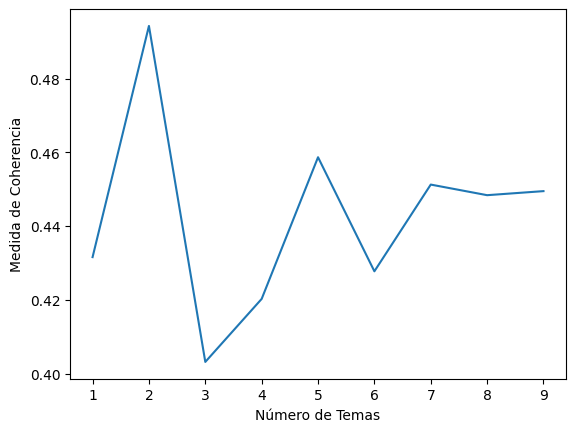

In [26]:

# Show graph
limit=10; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, valores_c)
plt.xlabel("Número de Temas")
plt.ylabel("Medida de Coherencia")
plt.show()

In [28]:
lda_model_opt = LdaMulticore(corpus = corpus,
    id2word = dictionary,
    num_topics = 2,
    random_state=123)
pyLDAvis.enable_notebook()
LDA_visualization = gensimvis.prepare(lda_model_opt, corpus, dictionary)
LDA_visualization

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.019565  0.0       1        1  52.679183
1     -0.019565  0.0       2        1  47.320817, topic_info=              Term         Freq        Total Category  logprob  loglift
68          murder  1300.000000  1300.000000  Default  30.0000  30.0000
24      base novel   771.000000   771.000000  Default  29.0000  29.0000
48          nuditi   680.000000   680.000000  Default  28.0000  28.0000
606  serial killer   296.000000   296.000000  Default  27.0000  27.0000
266            war   198.000000   198.000000  Default  26.0000  26.0000
..             ...          ...          ...      ...      ...      ...
82          suicid   166.028184   317.652745   Topic2  -5.6726   0.0994
323         sequel   171.125258   450.182765   Topic2  -5.6423  -0.2190
24      base novel   176.863305   771.250612   Topic2  -5.6093  -0.7244
42    femal nuditi   169.577196   584.882692   Topic2  -5.6514  -0.4899
48          nuditi   166.466402   680.897698   Topic2  -5.6699  -0.6604

[176 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
218       1  0.490480                   
218       2  0.510499                   
20        1  0.249209  aftercreditssting
20        2  0.747626  aftercreditssting
241       1  0.298618            airplan
...     ...       ...                ...
105       2  0.801342             worker
478       1  0.533914          world war
478       2  0.467442          world war
541       1  0.310593              zombi
541       2  0.688342              zombi

[252 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [29]:
def perplejidad_ntemas(dictionary, corpus, texts, start=1, limit=10, step=1):
 
    perplejidad_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics, 
                        random_state=123,
                        passes=20)
        model_list.append(model)
        perplejidad_values.append(np.exp2(-model.log_perplexity(corpus)))

    return model_list, perplejidad_values

In [31]:
modelos, valores_p = perplejidad_ntemas(dictionary=dictionary, corpus=corpus, texts=clean_keywords, start=1, limit=10, step=1)


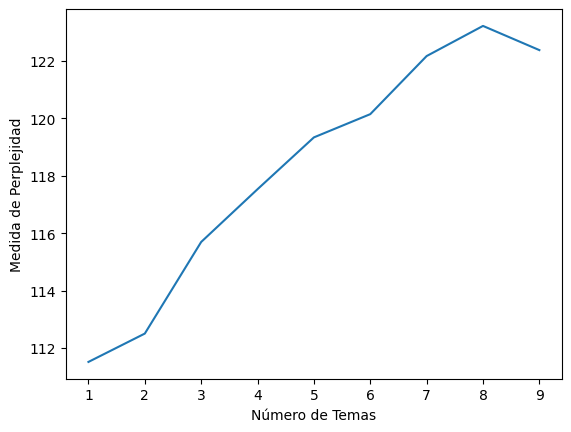

In [32]:
import matplotlib.pyplot as plt
# Show graph
limit=10; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, valores_p)
plt.xlabel("Número de Temas")
plt.ylabel("Medida de Perplejidad")

plt.show()

In [19]:
Estimacion = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=3,
    chunksize=1000,
    passes=20,
    iterations=400,
    alpha='auto',
    eta='auto',
    random_state=123,
    eval_every=None
)


pprint(Estimacion.print_topics())

[(0,
  '0.032*"murder" + 0.028*"biographi" + 0.023*"base novel" + 0.015*"violenc" + '
  '0.014*"reveng" + 0.014*"independ film" + 0.013*"short" + 0.012*"sport" + '
  '0.011*"sex" + 0.010*"base true stori"'),
 (1,
  '0.038*"" + 0.018*"sequel" + 0.016*"world war" + 0.015*"anim" + '
  '0.014*"zombi" + 0.014*"lgbt" + 0.013*"polit" + 0.012*"war" + 0.012*"come '
  'age" + 0.012*"comedi"'),
 (2,
  '0.174*"woman director" + 0.051*"stand comedi" + 0.026*"music" + '
  '0.022*"love" + 0.018*"teenag" + 0.018*"christma" + 0.015*"famili" + '
  '0.014*"friendship" + 0.012*"high school" + 0.010*"documentari"')]


### Guardar LDA

In [20]:
Estimacion.save('ModelosNLP/lda_model_estimacion.pkl')

### Guardar LDA

In [23]:
Estimacion_Pickle = LdaModel.load('ModelosNLP/lda_model_estimacion.pkl')

In [21]:
df_keywords_title[df_keywords_title['id']=='862'].index[0]

682

In [24]:
l=[Estimacion_Pickle.get_document_topics(item) for item in corpus]
#'La venganza del metegol'
l[682]

[(0, 0.29471806), (1, 0.3061052), (2, 0.39917675)]

In [25]:
def recomendador_LDA(id_movie, l, num_recomendaciones=5, df=df_keywords_title):
    # Crear una Serie que contiene como índice el 'id' y el valor correspondiente al índice de la película
    indices = pd.Series(df.index, index=df['id'])
    
    # Verificar si el id_movie está en los índices
    if id_movie not in indices.index:
        print(f"ID de película {id_movie} no encontrado.")
        return

    # Obtener el índice de la película a partir del id_movie
    idx = indices[id_movie]
    
    original_title = df.loc[idx, 'original_title']

    # Obtener las probabilidades de temas para la película
    topics_for_movie = l[idx]
    
    # Encontrar el tema con la mayor probabilidad (el tema dominante)
    tema_dominante, prob_dominante = max(topics_for_movie, key=lambda x: x[1])

    # Verificar los temas y probabilidades de la película original
    print(f"Tema dominante de la película '{original_title}' (ID: {id_movie}): {tema_dominante}")
    print(f"Probabilidades de temas para la película original: {topics_for_movie}")

    # Obtener todas las películas que comparten el mismo tema dominante
    peliculas_similares = [i for i, temas in enumerate(l) if any(tema == tema_dominante for tema, prob in temas)]
    
    # Excluir la película original (id_movie)
    peliculas_similares = [i for i in peliculas_similares if i != idx]

    # Obtener la probabilidad del tema dominante para las películas recomendadas
    probabilidad_tema_dominante = []
    for i in peliculas_similares:
        for tema, prob in l[i]:
            if tema == tema_dominante:
                probabilidad_tema_dominante.append((i, prob))
                break

    # Ordenar las películas recomendadas por la probabilidad del tema dominante en orden descendente
    probabilidad_tema_dominante = sorted(probabilidad_tema_dominante, key=lambda x: x[1], reverse=True)
    
    # Limitar el número de recomendaciones al parámetro num_recomendaciones
    probabilidad_tema_dominante = probabilidad_tema_dominante[:num_recomendaciones]

    # Obtener los índices y probabilidades
    peliculas_similares_indices = [i[0] for i in probabilidad_tema_dominante]
    peliculas_similares_probs = [i[1] for i in probabilidad_tema_dominante]

    # Crear un DataFrame para mostrar los resultados
    result_df = pd.DataFrame({
        'Índice': peliculas_similares_indices,
        'Título': df['original_title'].iloc[peliculas_similares_indices].values,
        'Probabilidad Tema Dominante': peliculas_similares_probs
    })

    # Imprimir el tema dominante de la película original y el título
    print(f"Tema dominante de la película original (ID: {id_movie}): {tema_dominante}")
    print(f"Título de la película original: {original_title}")
    
    # Imprimir las películas recomendadas con la probabilidad del tema dominante
    print("\nPelículas recomendadas:")
    #for i, row in result_df.iterrows():
     #   print(f"Índice: {row['Índice']}, Título: {row['Título']}, Probabilidad Tema Dominante: {row['Probabilidad Tema Dominante']:.4f}")
    
    # Retornar el DataFrame con los resultados
    return result_df

In [26]:
recomendador_LDA('862', l,num_recomendaciones=10)

Tema dominante de la película 'Toy Story' (ID: 862): 2
Probabilidades de temas para la película original: [(0, 0.29471806), (1, 0.3061052), (2, 0.39917675)]
Tema dominante de la película original (ID: 862): 2
Título de la película original: Toy Story

Películas recomendadas:


,Índice,Título,Probabilidad Tema Dominante
0,34093,एबीसीडी,0.755740
1,1902,Blindsight,0.755366
2,35474,In Old Santa Fe,0.718472
3,1815,Efter brylluppet,0.718376
4,24347,Cougar Hunting,0.718363
5,3275,Crazy,0.717189
6,521,Central do Brasil,0.695193
7,41810,Krisha,0.668519
8,43787,Fitoor,0.668089
9,42124,Top Spin,0.668084
